# 聚类分析简介

**聚类**（**clustering**）分析是经典的无监督学习问题。聚类分析通常是指，给定样本的特征，根据不同样本之间的相似度或者距离度量，将样本归结到若干个“类”中。

同样是分类问题，注意聚类是无监督学习，这与我们接下来要介绍的有监督的分类比如Logistic回归、分类树等有很大区别。在有监督学习中，根据标签，我们已经知道每个样本属于哪一类，机器学习的目的是为了通过特征对分类进行**预测**。而在聚类分析中，每个样本属于哪一类是未知的，我们必须根据样本特征对样本进行划分。

聚类分析通常可以作为一个单独的过程，比如对于电商，如果我们想了解顾客在“电子产品”、“生鲜”、“书籍”等品类中的购买偏好，我们可以根据这些顾客在不同品类中的购买量对顾客进行分类。

有时聚类也可以与其他分析结合起来，比如经过以上分类之后，将以上聚类分析的结果作为标签，我们可以使用顾客的其他特征，诸如性别、年龄、职业等，对以上结果标签使用监督学习的方法进行预测。这样当新的客户到来时，我们就可以使用以上监督学习的模型对新客户的类别进行预测。

接下来我们介绍以下聚类分析的基本原理。我们先从不同样本之间的“相似度”或者“距离”开始。

# 样本之间的距离度量

聚类分析的基础是使用一定的指标度量每个样本之间的距离。比如如果我们有以下数据，希望将以上同学分为“理科”和“文科”生，

In [1]:
import pandas as pd

scores = [
    {
        'name': 'Aragorn',
        '语文': 95,
        '数学': 115,
        '英语': 98,
        '物理': 95
    },
    {
        'name': 'Frodo',
        '语文': 115,
        '数学': 87,
        '英语': 108,
        '物理': 67
    },
    {
        'name': 'Bilbo',
        '语文': 110,
        '数学': 114,
        '英语': 115,
        '物理': 78
    },
    {
        'name': 'Gandalf',
        '语文': 98,
        '数学': 108,
        '英语': 78,
        '物理': 99
    },
    {
        'name': 'Legolas',
        '语文': 100,
        '数学': 103,
        '英语': 115,
        '物理': 90
    },
    {
        'name': 'Sam',
        '语文': 108,
        '数学': 102,
        '英语': 102,
        '物理': 98
    },
    {
        'name': 'Arwen',
        '语文': 88,
        '数学': 85,
        '英语': 78,
        '物理': 75
    },
]
scores = pd.DataFrame(scores).set_index('name')
scores.head(10)

,语文,数学,英语,物理
name,,,,
Aragorn,95,115,98,95
Frodo,115,87,108,67
Bilbo,110,114,115,78
Gandalf,98,108,78,99
Legolas,100,103,115,90
Sam,108,102,102,98
Arwen,88,85,78,75


其中每一个样本都可以看作是一个4维的向量，那么度量两个向量之间的距离，一个最简单的方法是直接使用**欧氏距离**（**Euclidean distance**）：$$d_{ij}=||x_i-x_j||_2=\left[\sum_{k=1}^K \left(x_{ik}-x_{jk}\right)^2\right]^{\frac{1}{2}}=\sqrt{\left(x_i- x_j\right)'\left(x_i- x_j\right)}$$

使用Numpy可以非常方便的计算这个距离，比如计算Aragorn和Frodo的距离：

In [2]:
import numpy as np

np.sqrt(
    np.inner(scores.iloc[0, :] - scores.iloc[1, :],
             scores.iloc[0, :] - scores.iloc[1, :]))


45.47526800360829

或者可以直接使用Numpy中的范数函数：

In [3]:
np.linalg.norm(scores.iloc[0, :] - scores.iloc[1, :])


45.47526800360829

实际上我们可以定义更加广义的**闵科夫斯基距离**（**Minkowski distance**）：$$d_{ij}=\left[\sum_{k=1}^K \left|x_{ik}-x_{jk}\right|^p\right]^{\frac{1}{p}}$$其中：
* 当$p=2$时，即$||x_i-x_j||_2$，使用L2范数，计算出的是欧氏距离;
* 当$p=1$时，即$||x_i-x_j||_1$，使用L1范数，计算出的曼哈顿距离（Manhattan distance）;
* 当$p=\infty$时，即$||x_i-x_j||_\infty=\max_k \left|x_{ik}-x_{jk}\right|$，切比雪夫距离（Chebyshev distance）;

所有以上的距离都可以使用范数函数进行计算，比如：

In [4]:
print("曼哈顿距离=", np.linalg.norm(scores.iloc[0, :] - scores.iloc[1, :], ord=1))
print("欧式距离=", np.linalg.norm(scores.iloc[0, :] - scores.iloc[1, :], ord=2))
print("切比雪夫距离=",
      np.linalg.norm(scores.iloc[0, :] - scores.iloc[1, :], ord=np.inf))


曼哈顿距离= 86.0
欧式距离= 45.47526800360829
切比雪夫距离= 28.0


此外，如果需要计算每个样本距离某一个样本的距离，我们可以使用广播功能和norm函数结合的方法，比如计算与第一个样本的距离，首先使用广播功能：

In [5]:
scores - scores.iloc[0, :]


,语文,数学,英语,物理
name,,,,
Aragorn,0,0,0,0
Frodo,20,-28,10,-28
Bilbo,15,-1,17,-17
Gandalf,3,-7,-20,4
Legolas,5,-12,17,-5
Sam,13,-13,4,3
Arwen,-7,-30,-20,-20


接下来使用norm函数的axis选项即可：

In [6]:
np.linalg.norm(scores - scores.iloc[0, :], axis=1)


array([ 0.        , 45.475268  , 28.35489376, 21.77154106, 21.97726098,
       19.05255888, 41.82104733])

可以发现与Aragorn最接近的是Sam。

虽然以上距离定义非常经典，但是仍然有很多问题，比如，如果我们对这些数据做一个描述性统计：

In [7]:
scores.describe()

,语文,数学,英语,物理
count,7.000000,7.0,7.000000,7.000000
mean,102.000000,102.0,99.142857,86.000000
std,9.433981,12.0,15.731376,12.622731
min,88.000000,85.0,78.000000,67.000000
25%,96.500000,94.5,88.000000,76.500000
50%,100.000000,103.0,102.000000,90.000000
75%,109.000000,111.0,111.500000,96.500000
max,115.000000,115.0,115.000000,99.000000


我们会发现：

* 语文、数学的平均分显著大于物理的平均分，其实这是由于语文、数学、外语的满分是120，物理的满分是100分
* 语文的标准差很小，但是英语的标准差就很大

此外，如果我们计算以下四个成绩的相关性：

In [8]:
scores.corr()

,语文,数学,英语,物理
语文,1.000000,0.032389,0.691780,-0.291114
数学,0.032389,1.000000,0.256918,0.632677
英语,0.691780,0.256918,1.000000,-0.209831
物理,-0.291114,0.632677,-0.209831,1.000000


会发现：

* 语文和数学成绩几乎不相关，和英语成绩高度相关，和物理成绩有负相关系；
* 数学和英语成绩几乎不相关，但是数学和物理成绩高度相关

可以想象，如果我们使用以上定义的距离，那么就会：

* （尺度问题）忽略了不同科目之间平均值的差异，平均值越大的特征（科目）会更大的影响距离的度量；
* （相关问题）忽略了不同科目之间的相关性，比如数学和物理、语文和英语之间有很强的相关性，有理由相信这些相关性强的科目携带的共同的信息，如果携带相同信息的变量很多，那么就会极大影响距离度量。

因而在以上基础之上，通常会对欧氏距离进行推广，使用变量之间的协方差矩阵解决变量之间的尺度问题和相关问题，即**马氏距离**（**Mahalanobis distance**）：$$d_{ij}=\left[\left(x_i-x_j\right)'\Sigma^{-1}\left(x_i-x_j\right)\right]^{\frac{1}{2}}$$

其中$\Sigma$为协方差矩阵，比如以上数据的协方差矩阵：

In [9]:
scores.cov()

,语文,数学,英语,物理
语文,89.000000,3.666667,102.666667,-34.666667
数学,3.666667,144.000000,48.500000,95.833333
英语,102.666667,48.500000,247.476190,-41.666667
物理,-34.666667,95.833333,-41.666667,159.333333


如果忽略掉协方差矩阵，其实就是欧氏距离。

如果需要计算马氏距离，可以首先将数据矩阵右乘一个$\Sigma^{-1/2}$，然后使用norm函数计算即可。实际上，如果我们记数据矩阵为：$$X=\left[x_{ik}\right]_{N\times K}=\left[\begin{array}{c}
x_{1}'\\
x_{2}'\\
\vdots\\
x_{N}'
\end{array}\right]=\left[\begin{array}{cccc}
x_{11} & x_{12} & \cdots & x_{1K}\\
x_{21} & x_{22} & \cdots & x_{2K}\\
\vdots & \vdots & \ddots & \vdots\\
x_{N1} & x_{N2} & \cdots & x_{NK}
\end{array}\right]$$
那么：$$\tilde{X}=X\Sigma^{-1/2}=\left[\begin{array}{c}
x_{1}'\\
x_{2}'\\
\vdots\\
x_{N}'
\end{array}\right]\Sigma^{-1/2}=\left[\begin{array}{c}
x_{1}'\Sigma^{-1/2}\\
x_{2}'\Sigma^{-1/2}\\
\vdots\\
x_{N}'\Sigma^{-1/2}
\end{array}\right]$$
从而只需要计算不同样本之间$\tilde{X}$的欧式距离即可得到马氏距离，比如我们还是计算与第一个样本之间的距离：

In [10]:
#实对称矩阵的特征值分解
ev, evec = np.linalg.eigh(scores.cov())
#计算\Sigma^{-1/2}
sigma_1_2 = evec @ np.diag(np.power(ev, -0.5)) @ evec.T
sigma_1_2

array([[ 0.14436173,  0.0042541 , -0.04163505,  0.0093362 ],
       [ 0.0042541 ,  0.11467629, -0.02330029, -0.04645397],
       [-0.04163505, -0.02330029,  0.08467504,  0.01637252],
       [ 0.0093362 , -0.04645397,  0.01637252,  0.10719221]])

进而计算$$\tilde{X}=X\Sigma^{-1/2}$$

In [11]:
X_tilde = scores @ sigma_1_2
X_tilde

,0,1,2,3
name,,,,
Aragorn,11.010289,6.895357,3.218680,7.332499
Frodo,13.100645,4.837211,3.426707,5.982277
Bilbo,12.304950,7.238104,3.778597,5.975061
Gandalf,12.283642,6.385575,1.628866,7.787004
Legolas,10.926572,5.376677,4.647721,7.678999
Sam,12.693157,5.227305,3.368146,8.444838
Arwen,10.518111,4.820375,2.188183,6.189470


最后计算距离：

In [12]:
np.linalg.norm(X_tilde - X_tilde.iloc[0, :], axis=1)


array([0.        , 3.2360355 , 1.98740215, 2.14834499, 2.11556604,
       2.62184614, 2.62987242])

可以发现与第一个最接近的变成了Bilbo。

除了以上的方法外，还有一个非常常用的相似度度量是余弦夹角：$$\cos\theta=\frac{x_i' x_j}{|| x_i ||_2 \cdot || x_j ||_2}$$其中分子上为两个向量的内积，而分母上为两个向量的$L^2$范数。$\cos\theta$越接近于1代表夹角越小，因而越相似。

因而在这个度量中，只有两个向量之间的**角度**是重要的，范数（距离0的长度）并不重要。

由于矩阵与向量的乘机就是内积，因而为了计算这个夹角，分子上可以使用矩阵乘积计算：

In [13]:
cos_fz = scores @ scores.iloc[0, :].T
cos_fz

name
Aragorn    40879
Frodo      37879
Bilbo      42240
Gandalf    38779
Legolas    41165
Sam        41296
Arwen      32904
dtype: int64

然后计算分母：

In [14]:
cos_fm = np.linalg.norm(scores, axis=1) * np.linalg.norm(scores.iloc[0, :])
cos_fm = pd.Series(cos_fm, index=scores.index)
cos_fm

name
Aragorn    40879.000000
Frodo      38863.304196
Bilbo      42605.539487
Gandalf    38971.495827
Legolas    41403.139808
Sam        41473.181744
Arwen      33023.778736
dtype: float64

最后计算余弦相似度：

In [15]:
cos_similarity = cos_fz / cos_fm
cos_similarity

name
Aragorn    1.000000
Frodo      0.974673
Bilbo      0.991420
Gandalf    0.995061
Legolas    0.994248
Sam        0.995728
Arwen      0.996373
dtype: float64

可以看到这里反倒是Arwen跟Aragorn最相似，究其原因，是因为虽然Arwen的成绩普遍很低，所以计算距离时与Aragorn的距离差很远；但是两者的夹角却可以很小，从这点来看，余弦相似度忽略了分数的绝对高低的差别。

# 类及其特征

聚类的目的是为了让更相似的尽量在一类（cluster），而每个类应该足够的小。接下来我们主要讨论**硬聚类**（**hard clustering**），即每个样本都只能归属于一个类。

如果我们已经将样本分为$M$个类$G_1,G_2,...,G_M$，对于每个类，我们可以定义其：

* 中心，即每个类$G_m$中特征$x$的均指向量$x_m$；
* 直径，即每个类$G_m$中距离最远的两个样本之间的距离
* 方差，即每个类$G_m$的方差

此外，对于两个类$G_m$和$G_{m'}$，我们还可以度量两个类之间的距离：

* 单连接（single, 或最短距离），即两个类之间距离最近的两个样本之间的距离
* 完全连接（complete, 或最长距离），即两个类之间距离最远的两个样本之间的距离
* 中心距离，即两个类的中心之间的距离
* 平均距离，两个类中每两个样本之间距离的平均值

# 层次聚类

最简单的聚类方法是所谓的**层次聚类**（**Hierarchical clustering**）。该方法从每个样本开始，逐步的将距离最近的样本合并为一类。层次聚类有分为**聚合**（**agglomerative**）和**分裂**（**divisive**）两种，其中聚合指自下而上的将样本逐步合并，而分裂则是相反的过程。

一般比较常用的是聚合聚类，聚合聚类需要确定三个基本的要素：

* 距离或者相似度，可以是我们上面介绍的所有距离、相似度的度量
* 合并规则，比如当往每个类里面添加元素时，可以要求使得每个类的方差最小、直径最小，或者任意两个类之间的距离（单连接、完全连接、中心距离、平均距离最小）
* 停止条件，可以是类的个数达到一定数量、类的直径达到一定程度等等，就停止聚类。

比如，针对以上数据，我们可以使用Scikit-Learn进行简单的聚合聚类：

In [16]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(n_clusters=3)
clustering = clustering_model.fit(scores)
result_cluster = pd.DataFrame({'hirac_eucl': clustering.labels_},
                              index=scores.index)
result_cluster

,hirac_eucl
name,
Aragorn,1
Frodo,2
Bilbo,1
Gandalf,0
Legolas,1
Sam,1
Arwen,0


默认的使用欧氏距离、合并规则为最小化每个类的方差。我们可以使用图的方式很直观的理解以上过程：

In [17]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


clustering = AgglomerativeClustering(distance_threshold=0,
                                     n_clusters=None).fit(scores)
plt.title('Hierarchical clustering')
plot_dendrogram(clustering, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

<Figure size 640x480 with 1 Axes>

当然我们也可以使用其他距离度量，比如cos夹角（使用cos夹角不能使用最小方差的合并规则，这里使用最小化类之间的平均距离）：

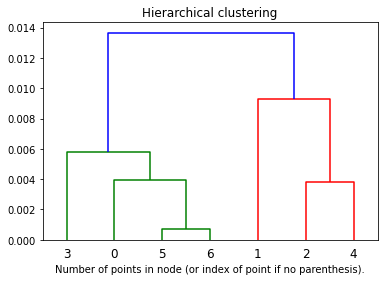

,hirac_eucl,hirac_cos
name,,
Aragorn,1,0
Frodo,2,2
Bilbo,1,1
Gandalf,0,0
Legolas,1,1
Sam,1,0
Arwen,0,0


In [18]:
clustering = AgglomerativeClustering(distance_threshold=0,
                                     n_clusters=None,
                                     affinity='cosine',
                                     linkage='average').fit(scores)
plt.title('Hierarchical clustering')
plot_dendrogram(clustering, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
clustering = AgglomerativeClustering(n_clusters=3,
                                     affinity='cosine',
                                     linkage='average').fit(scores)
result_cluster['hirac_cos'] = pd.Series(clustering.labels_, index=scores.index)
result_cluster

更加具体的说明可以参考 https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

聚类之后可以方便的计算类的中心、方差等，比如：

In [19]:
merged_scores = pd.concat([scores, result_cluster], axis=1)
merged_scores.groupby('hirac_cos').mean().drop('hirac_eucl', axis=1)


,语文,数学,英语,物理
hirac_cos,,,,
0,97.25,102.5,89.0,91.75
1,105.00,108.5,115.0,84.00
2,115.00,87.0,108.0,67.00


In [20]:
merged_scores.groupby('hirac_cos').var().drop('hirac_eucl', axis=1)


,语文,数学,英语,物理
hirac_cos,,,,
0,68.916667,164.333333,164.0,127.583333
1,50.000000,60.500000,0.0,72.000000
2,NaN,NaN,NaN,NaN


# K-means聚类

K-means聚类是非常常用的聚类方法之一，该方法将所有样本进行划分，使得每个样本到其类中心的平方和最小。如果我们希望分为$M$类，那么，记$\bar{x}_m$为第$m$类的中心，那么那么损失函数定义为：$$\sum_{m=1}^M{\sum_{_i\in G_m}{||x_i-\bar{x}_m||^2_2}}$$

算法的目的是最小化以上目标函数，那么就需要确定每一个$i$所属的组。然而，每个样本所属组有很多情况，这个情况数是指数级别的，实际上解以上最优化问题是一个NP-hard问题。

现实中在求解以上问题时，会先从一个简单的划分开始，通过迭代的方法直到收敛，我们在此不详细介绍算法的具体步骤。Scikit-Learn中已经有该算法的实现：

In [21]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=3).fit(scores)
merged_scores['k_means'] = pd.Series(clustering.labels_, index=scores.index)
merged_scores

,语文,数学,英语,物理,hirac_eucl,hirac_cos,k_means
name,,,,,,,
Aragorn,95,115,98,95,1,0,2
Frodo,115,87,108,67,2,2,0
Bilbo,110,114,115,78,1,1,0
Gandalf,98,108,78,99,0,0,2
Legolas,100,103,115,90,1,1,0
Sam,108,102,102,98,1,0,2
Arwen,88,85,78,75,0,0,1


In [22]:
merged_scores.groupby('k_means').mean()

,语文,数学,英语,物理,hirac_eucl,hirac_cos
k_means,,,,,,
0,108.333333,101.333333,112.666667,78.333333,1.333333,1.333333
1,88.000000,85.000000,78.000000,75.000000,0.000000,0.000000
2,100.333333,108.333333,92.666667,97.333333,0.666667,0.000000


与层次聚类不同的是，该算法可以对新的样本归属于哪一类进行预测：

In [23]:
clustering.predict(np.array([[120, 120, 120, 100], [50, 100, 100, 50]]))


array([0, 1], dtype=int32)

以上计算中，Scikit-Learn会自动计算初始分类，并选择合适的算法进行拟合，如果需要控制细节，可以参考：https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

此外，算法中还涉及到类别个数的选择，一般可以通过计算每个类别的平均直径，如果额外增加类别对平均直径的降低作用不大，那么就无需增加类别个数。

# 一个实例：零售商的客户划分

接下来我们使用一个实际数据展示聚类分析的用法。

在营销中，将客户具体划分为不同的细分市场特别重要，但是在进行市场开发时，通常没有经过标记（标签化）的数据，我们可以还是用聚类分析对客户进行一定程度上的划分。在此基础之上，我们可以分析不同购买渠道、地区的客户具有何种特点等。

首先读入数据：

In [24]:
wholesale = pd.read_csv("csv/wholesale.csv")
wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


其中Channel是购买的渠道，Region是地区，其他变量是不同种类的商品的消费量。

在这里，我们的目的不是为了预测而是分析渠道、地区特点，因而使用层次聚类即可，不妨使用余弦相似度先进行一个简单的聚类：

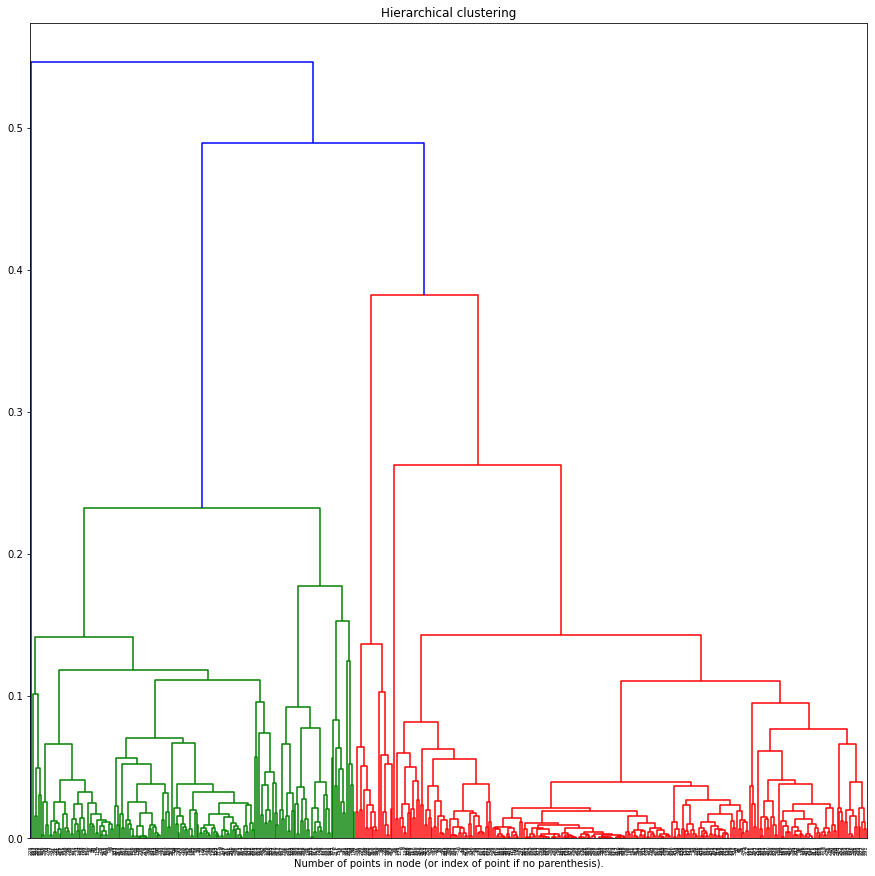

In [25]:
sales = wholesale.drop(['Channel', 'Region'], axis=1)
clustering = AgglomerativeClustering(distance_threshold=0,
                                     n_clusters=None,
                                     affinity='cosine',
                                     linkage='average').fit(sales)
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.title('Hierarchical clustering')
plot_dendrogram(clustering, truncate_mode='level', p=20)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

这里我们不妨分为5类：

In [26]:
clustering = AgglomerativeClustering(n_clusters=5,
                                     affinity='cosine',
                                     linkage='average').fit(sales)
sales['cluster'] = clustering.labels_
sales.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,12669,9656,7561,214,2674,1338,2
1,7057,9810,9568,1762,3293,1776,0
2,6353,8808,7684,2405,3516,7844,0
3,13265,1196,4221,6404,507,1788,2
4,22615,5410,7198,3915,1777,5185,2


查看中心：

In [27]:
sales.groupby('cluster').mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,,
0,4854.688235,10093.211765,14150.188235,1713.458824,6042.700000,1882.758824
1,6107.250000,2693.150000,3743.300000,12832.150000,513.550000,1153.450000
2,17389.229839,3140.342742,4018.346774,3215.306452,892.709677,1262.620968
3,1869.000000,577.000000,572.000000,950.000000,4762.000000,203.000000
4,18291.000000,1266.000000,21042.000000,5373.000000,4173.000000,14472.000000


In [28]:
sales.groupby('cluster').describe()

Fresh                                                          \
         count          mean           std      min       25%      50%   
cluster                                                                  
0        170.0   4854.688235   6470.260120      3.0   1033.25   2873.5   
1         20.0   6107.250000   7168.286317      3.0   2418.00   4570.0   
2        248.0  17389.229839  13564.936414    622.0   8561.25  14004.5   
3          1.0   1869.000000           NaN   1869.0   1869.00   1869.0   
4          1.0  18291.000000           NaN  18291.0  18291.00  18291.0   

                              Milk                ... Detergents_Paper  \
              75%       max  count          mean  ...              75%   
cluster                                           ...                    
0         5949.50   44466.0  170.0  10093.211765  ...           7568.5   
1         8031.25   32717.0   20.0   2693.150000  ...            819.0   
2        21506.75  112151.0  248.0   3140.342742  ...            985.5   
3         1869.00    1869.0    1.0    577.000000  ...           4762.0   
4        18291.00   18291.0    1.0   1266.000000  ...           4173.0   

                 Delicassen                                                \
             max      count          mean          std      min       25%   
cluster                                                                     
0        40827.0      170.0   1882.758824  4010.062038      3.0    445.25   
1         1377.0       20.0   1153.450000  1331.994210     46.0    170.50   
2         6707.0      248.0   1262.620968  1463.551698      3.0    408.25   
3         4762.0        1.0    203.000000          NaN    203.0    203.00   
4         4173.0        1.0  14472.000000          NaN  14472.0  14472.00   

                                    
             50%      75%      max  
cluster                             
0         1215.0   1951.0  47943.0  
1          810.5   1595.0   5609.0  
2          833.5   1627.5  14351.0  
3          203.0    203.0    203.0  
4        14472.0  14472.0  14472.0  

[5 rows x 48 columns]

进一步可以用图的方式查看聚类结果：

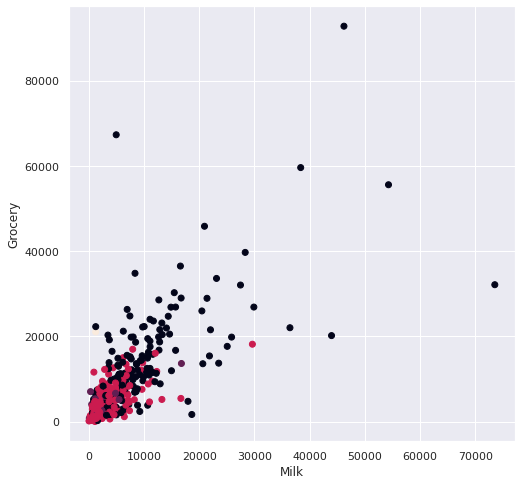

In [29]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
## 使图形直接插入到jupyter中
%matplotlib inline
# 设定图像大小
plt.rcParams['figure.figsize'] = (8.0, 8.0)

plt.scatter(sales['Milk'],sales['Grocery'],c=sales['cluster']) ##散点图
plt.xlabel('Milk')
plt.ylabel("Grocery")
plt.show() ## 画图

还可以分地区、渠道查看各个类别的个数，比如查看第0类：

In [30]:
wholesale_dummies = pd.get_dummies(sales['cluster'], prefix='cluster')
wholesale_dummies['Region'] = wholesale['Region']
wholesale_dummies['Channel'] = wholesale['Channel']
wholesale_dummies.pivot_table('cluster_0',
                              index='Region',
                              columns='Channel',
                              aggfunc='mean')


Channel,1,2
Region,,
1,0.254237,0.833333
2,0.142857,0.736842
3,0.218009,0.723810


可以发现，第0类顾客更偏向于通过渠道2购买，而地区1似乎有更多的第0类顾客比例。

我们将在后面介绍如何使用其他特征，如地区、渠道等对分类进行预测。

# 作业

使用https://archive.ics.uci.edu/ml/datasets/Online+Retail 中的数据，根据StockCode的第一位进行分类，计算每个消费者每一类的消费量，进而进行聚类分析，分析每个国家的类别情况。